In [1]:
# Load Relevant Modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
import xarray as xr
import sys
from tqdm.notebook import tqdm

In [2]:
# Define the BSP function that is called and recursively subdivides a 2D distribution

def binary_space_partition(x, y, z, v, c, a, u, w, q, depth: int, axis: int = 0):
    """
    Create a binary space partition tree from a set of point coordinates
    
    >>> binary_space_partition(numpy.array([1,2,4,2]),
    ...                        numpy.array([3,4,8,1]), 
    ...                        depth=1)
    ([1, 4, 1, 8], (([1, 2, 3, 4], None), ([2, 4, 1, 8], None)))
    
    Args:
        x: x coordinates
        y: y coordinates
        v: distribution data (e.g. volume)
        c, a, u, w, q: variables of interest to integrate in a BSP bin (e.g. total volume/surface area)
        z: variables of interest to distribution-weighted average in a BSP bin (e.g. volume-averaged carbon)
        depth: maximum tree depth
        axis: initial branch axis
        
    Returns:
        A tuple (bounds, (left, right)) where bounds is the bounding
        box of the contained points and left and right are the results
        of calling binary_space_partition on the left and right tree
        branches. Once the tree has reached 'depth' levels then the
        second element will be None
    """
    
    bounds = (x.min(), x.max(), y.min(), y.max())
    
    # Calculate diagnostics for this partition
    vsum = v.sum()
    csum = c.sum()
    asum = a.sum()
    usum = u.sum()
    wsum = w.sum()
    qsum = q.sum()
    ymean = (y*c).sum()/csum
    xmean = (x*c).sum()/csum
    zmean = (z*c).sum()/csum

    
    if depth == 0 or x.size <= 2:
        # Add diagnostic to  the output
        return [bounds, xmean, ymean, zmean, vsum, csum,  asum, usum, wsum, qsum, None]
    
    # Sort coordinates along axis
    if axis == 0:
        idx = np.argsort(x)
    elif axis == 1:
        idx = np.argsort(y)
    else:
        raise ArgumentError
    
    # Indexes for left and right branches
    # Use volume on current branch to find the split at the centre point in volume
    vtot_half = v.sum()/2.
    v1 = v[idx].cumsum()
    
    idx_l = idx[v1<vtot_half]
    idx_r = idx[v1>vtot_half]
    
    # Recurse into the branches
    left = binary_space_partition(x[idx_l], y[idx_l], z[idx_l], v[idx_l], c[idx_l], a[idx_l], u[idx_l], w[idx_l] ,q[idx_l], depth-1, (axis+1)%2)  
    right = binary_space_partition(x[idx_r], y[idx_r], z[idx_r], v[idx_r], c[idx_r], a[idx_r], u[idx_r], w[idx_r] ,q[idx_r], depth-1, (axis+1)%2)

    return [left, right]

In [13]:
chunks = {'time': 1}
RR_NEMO = 106/16

## Load a text file that includes the list of strings pointing to the relevant data. 
## This ensures that pull requests don't continuously overwrite hardcoded file paths.

filename = 'folders_list.txt'
with open(filename) as f:
    mylist = f.read().splitlines() 

## Load the data using xarray. 

NEMO_historical_tracers = xr.open_mfdataset(mylist[0],decode_times=True)#, chunks = chunks)
NEMO_historical_fluxes = xr.open_mfdataset(mylist[1],decode_times=True)#, chunks = chunks)
NEMO_historical_TS = xr.open_mfdataset(mylist[2],decode_times=True)#, chunks = chunks)

## Align time axis across all datasets
NEMO_historical_tracers.coords['time'] = NEMO_historical_TS['time']

## Grid co-ordinates have an unnecessary 'time' dimension which is dropped here. 

NEMO_historical_tracers['nav_lat'] = NEMO_historical_tracers['nav_lat'].isel(time=0).drop('time')
NEMO_historical_tracers['nav_lon'] = NEMO_historical_tracers['nav_lon'].isel(time=0).drop('time')
NEMO_historical_tracers['cell_area'] = NEMO_historical_tracers['cell_area'].isel(time=0).drop('time')
NEMO_historical_TS['nav_lat'] = NEMO_historical_TS['nav_lat'].isel(time=0).drop('time')
NEMO_historical_TS['nav_lon'] = NEMO_historical_TS['nav_lon'].isel(time=0).drop('time')
NEMO_historical_TS['cell_area'] = NEMO_historical_TS['cell_area'].isel(time=0).drop('time')
NEMO_historical_fluxes['nav_lat'] = NEMO_historical_fluxes['nav_lat'].isel(time=0).drop('time')
NEMO_historical_fluxes['nav_lon'] = NEMO_historical_fluxes['nav_lon'].isel(time=0).drop('time')
NEMO_historical_fluxes['cell_area'] = NEMO_historical_fluxes['cell_area'].isel(time=0).drop('time')

## Load the 9 basins masks

NEMO_mask = xr.open_mfdataset(mylist[3] ,decode_times=True, chunks = chunks)

## The mask file has different names for the dimensions and \
# co-ordinates - here I rename the co-ordinates to be the same as the native NEMO names

NEMO_mask_renamed = NEMO_mask.rename_dims(dict(j='x', i='y', lev='deptht'))\
.rename(dict(lev='deptht', lon='nav_lon', lat='nav_lat'))

In [14]:
## Specify tracers
NEMO_C_star = NEMO_historical_tracers.Cstar
NEMO_DIC = NEMO_historical_tracers.DiC

## Define grid area, volume and depth, as well as land mask
NEMO_land_mask = (NEMO_C_star/NEMO_C_star)

NEMO_area = NEMO_historical_tracers.cell_area*NEMO_land_mask.isel(deptht=0)
NEMO_depth = NEMO_historical_tracers.deptht.values

dArea_3D = NEMO_area.expand_dims({'deptht':NEMO_depth.size},axis=1).assign_coords(deptht=NEMO_depth)
dSArea_3D = dArea_3D.copy(deep=True)

NEMO_volume = dArea_3D*NEMO_historical_TS.e3t
vol500 = NEMO_volume.copy(deep=True)
depth_ind = np.argmin(NEMO_depth<500)

# Creating 4D mask
NEMO_mask_4D = NEMO_mask_renamed.expand_dims({'time':NEMO_historical_tracers.time.size},axis=1)\
.assign_coords(time=NEMO_historical_tracers.time)
# Defining 9 basins
Basins = NEMO_mask.Basins.values

## Specify T,S
NEMO_T = NEMO_historical_TS.votemper
NEMO_S = NEMO_historical_TS.vosaline

## Specify fluxes
NEMO_hfds = NEMO_historical_TS.sohefldo*NEMO_area 
NEMO_wfo = NEMO_historical_TS.sowaflup*NEMO_area 
NEMO_Cflux = NEMO_historical_fluxes.CO2FLUX/(24*3600)*NEMO_area 

## Turn fluxes into 3D files
NEMO_hfds_3D = NEMO_hfds.expand_dims({'deptht':NEMO_depth.size},axis=1).assign_coords(deptht=NEMO_depth) # units: W
NEMO_wfo_3D = NEMO_wfo.expand_dims({'deptht':NEMO_depth.size},axis=1).assign_coords(deptht=NEMO_depth) # units: kg/s
NEMO_Cflux_3D = NEMO_Cflux.expand_dims({'deptht':NEMO_depth.size},axis=1).assign_coords(deptht=NEMO_depth) # units: mmol-C/s 

## Set fluxes, area to be zero in the interior
## We also set our volume array that will be used for binning to be zero below a given depth

NEMO_hfds_3D[:,1:,:,:] = 0
NEMO_wfo_3D[:,1:,:,:] = 0
NEMO_Cflux_3D[:,1:,:,:] = 0
dSArea_3D[:,1:,:,:] = 0
vol500[:,depth_ind:,:,:] = 0


In [7]:
## Flatten variables of interest into 2D arrays (time x flattened spatial dimensions)
volcello_flattened = (NEMO_volume.stack(z=("y", "x", "deptht")))
vol_500_flattened = vol500.stack(z=("y", "x", "deptht"))
bigthetao_flattened = (NEMO_T.stack(z=("y", "x", "deptht")))
so_flattened = (NEMO_S.stack(z=("y", "x", "deptht")))
C_star_flattened = (NEMO_C_star.stack(z=("y", "x", "deptht")))
areacello_flattened = (dSArea_3D.stack(z=("y", "x", "deptht")))
mask_flattened = (NEMO_mask_4D.mask_NEMO.stack(z=("y", "x", "deptht")))
hfds_flattened = NEMO_hfds_3D.stack(z=("y", "x", "deptht"))
wfo_flattened = NEMO_wfo_3D.stack(z=("y", "x", "deptht"))
Cflux_flattened = NEMO_Cflux_3D.stack(z=("y", "x", "deptht"))

## Shorten their names (not necessary but makes for easier code readability)
BA = mask_flattened
V = volcello_flattened
V500 = vol_500_flattened
S = ((so_flattened))
T = ((bigthetao_flattened))
C_star = C_star_flattened
A = (areacello_flattened)
HF = hfds_flattened
WFO = wfo_flattened
CF = Cflux_flattened

N = A.shape[1] 

## Define the BSP tree depth (i.e., we produce 2**depth bins)
## Define the window of time over which BSP bins are calculated - this is important when parallelising this process

depth=7
window = 2
# print(sys.argv[1])
ti = 0 #int(sys.argv[1])

## Define month weights
weights = [31,28.25,31,30,31,30,31,31,30,31,30,31]
months = np.nancumsum(weights)/np.sum(weights)
months_repeating = np.tile(months, int(window/12))

In [8]:
## Create empty arrays that will be filled by the BSP-ised bins
## Array sizes are (Basin, time, BSP depth) other than for the bin corners which are
## (Basin, time, BSP depth, 4)

partitions_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth, 4))
T_mean_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))
S_mean_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))
C_star_mean_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))
V_sum_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))
V500_sum_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))
A_sum_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))
hfds_sum_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))
wfo_sum_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))
Cflux_sum_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))

## Run a loop over all times of interest 

time_array = np.zeros(window)
for i in tqdm(range(ti*window, (ti+1)*window)):
    time_array[int(i-ti*window)] = i
    for j in tqdm(range(Basins.size)):
        # Get a single timestep as numpy, not dask
        ## The x and y axes
        x = S[i,:].values
        y = T[i,:].values
        ## Any tracers to find the weighted mean of
        z = C_star[i,:].values
        ## The 2D distribution to calculate bins on
        v = V500[0,:].values
        ## Summed variables to output for each bin
        c = V[0,:].values*BA[j,i,:].values
        a = A[0,:].values*BA[j,i,:].values
        u = HF[i,:].values*BA[j,i,:].values
        w = WFO[i,:].values*BA[j,i,:].values
        q = CF[i,:].values*BA[j,i,:].values
        
        # Clean out NAN values
        idx = np.isfinite(x)
        x = x[idx]
        y = y[idx]
        z = z[idx]
        v = v[idx]
        c = c[idx]
        a = a[idx]
        u = u[idx]
        w = w[idx]
        q = q[idx]

        ## Run the BSP code to calculate the variables of interest
        b_results = binary_space_partition(x,y,z,v,c,a,u,w,q, depth=depth, axis=1)

        ## The BSP results come out as a long list of different numbers in the format
        ## [bounds, xmean, ymean, zmean, vsum, csum,  asum, usum, wsum, qsum], where bounds 
        ## itself is a tuple (x0,y0,x1,y1).
        ## Below, we split the list into arrays of each variable

        bsp_flat = list(itertools.chain(*b_results))

        while (len(bsp_flat) <= 2**depth):
            bsp_flat = list(itertools.chain(*bsp_flat))
        partitions_hist[j,int(i-ti*window),:,:] = np.array(bsp_flat[::11])
        T_mean_hist[j,int(i-ti*window),:] = np.array(bsp_flat[1::11])
        S_mean_hist[j,int(i-ti*window),:] = np.array(bsp_flat[2::11])
        C_star_mean_hist[j,int(i-ti*window),:] = np.array(bsp_flat[3::11])
        V500_sum_hist[j,int(i-ti*window),:] = np.array(bsp_flat[4::11])
        V_sum_hist[j,int(i-ti*window),:] = np.array(bsp_flat[5::11])
        A_sum_hist[j,int(i-ti*window),:] = np.array(bsp_flat[6::11])
        hfds_sum_hist[j,int(i-ti*window),:] = np.array(bsp_flat[7::11])
        wfo_sum_hist[j,int(i-ti*window),:] = np.array(bsp_flat[8::11])
        Cflux_sum_hist[j,int(i-ti*window),:] = np.array(bsp_flat[9::11])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

/Users/taimoor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/Users/taimoor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/Users/taimoor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
## We redefine each outputted numpy array as an xarray DataArray with the goal of saving it as a netCDF file

da_partitions_hist = xr.DataArray(data = partitions_hist, dims = ["Basin","Time", "Depth", "Coords"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth= np.arange(2**depth), Coords = np.arange(4)),
                        attrs=dict(description="[x0,y0,xmax,ymax] bounds of BSP framework", variable_id="Partitions"))
da_S_mean_hist = xr.DataArray(data = S_mean_hist, dims = ["Basin", "Time", "Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Mean Salinity", units="g/kg", variable_id="S"))
da_T_mean_hist = xr.DataArray(data = T_mean_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Mean Temperature", units="K", variable_id="T"))
da_C_star_mean_hist = xr.DataArray(data = C_star_mean_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Mean C_star", units="mmol-C/m3", variable_id="C_star"))
da_V_sum_hist = xr.DataArray(data = V_sum_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Total Volume", units="m^3", variable_id="Basin V_sum"))
da_A_sum_hist = xr.DataArray(data = A_sum_hist, dims = ["Basin", "Time","Depth"],
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Total Area", units="m^2", variable_id="Basin A_sum"))
da_hfds_sum_hist = xr.DataArray(data = hfds_sum_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Heat Flux", units="W", variable_id="hfds"))
da_wfo_sum_hist = xr.DataArray(data = wfo_sum_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="FW Flux", units="kg/s", variable_id="wfo"))
da_Cflux_sum_hist = xr.DataArray(data = Cflux_sum_hist, dims = ["Basin", "Time","Depth"],
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Carbon Flux", units="mmol-C/s", variable_id="Cflux"))

## Input all xarray DataArrays into a DataSet


ds_BSP = xr.Dataset()
ds_BSP['Partitions_hist'] = da_partitions_hist
ds_BSP['T_mean_hist'] = da_T_mean_hist
ds_BSP['S_mean_hist'] = da_S_mean_hist
ds_BSP['C_star_mean_hist'] = da_C_star_mean_hist
ds_BSP['V_sum_hist'] = da_V_sum_hist
ds_BSP['A_sum_hist'] = da_A_sum_hist
ds_BSP['hfds_sum_hist'] = da_hfds_sum_hist
ds_BSP['wfo_sum_hist'] = da_wfo_sum_hist
ds_BSP['Cflux_sum_hist'] = da_Cflux_sum_hist

ds_BSP.to_netcdf(mylist[4]+'BSP_NEMO_TS_hist_area_%i_%i.nc' %(ti*window, (ti+1)*window-1))

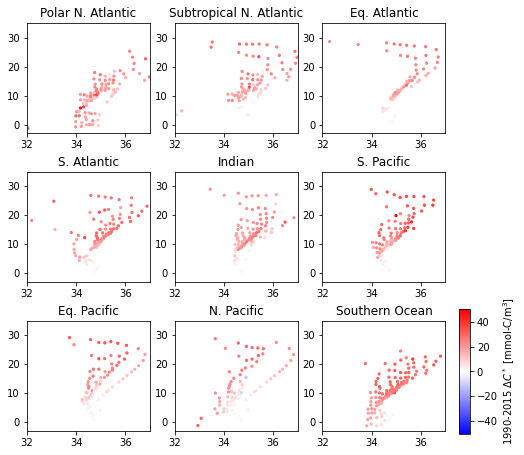

In [11]:
fig, axs = plt.subplots(3,3, figsize=(15*0.5,15*0.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .35, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

for i in range(Basins.size):
    axs[i].scatter(da_T_mean_hist[i,1,:].values, da_S_mean_hist[i,1,:].values, 5,\
                da_C_star_mean_hist[i,1,:]-da_C_star_mean_hist[i,0,:], cmap=plt.cm.bwr, vmin=-50, vmax=50)
    axs[i].set_title(Basins[i])
    axs[i].set_xlim(32,37)
    axs[i].set_ylim(-3,35)
    
m = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
m.set_clim(-50, 50)

cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('1990-2015 $\Delta C^*$ [mmol-C/m$^3$]') 
# plt.savefig('/g/data/e14/txs156/Figures/BSP_C_star_CARBO_MM.png', dpi=300, bbox_inches='tight')
plt.show()